# Association

Modelling the explicit labelling of observations from different population components.

Model definition and simulation is done using pyStan with code in the `stan/` directory.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import cmdstanpy

In [2]:
# for nice plots when shown on GitHub nb viewer
import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')

## A simple mixture model

Consider observations drawn from a mixture of 2 gaussian distributions with different means and the same standard deviation. Each population has an associated weight, $w$, the set of which forms a 2-simplex. The model can be parameterised with a latent categorical variable or *label*, $\lambda$:

$$
\lambda \sim Categorical(w) 
$$

The observation $y_n$ is distributed according to which mixture componenet it is generated from.

$$
y_k \sim Normal(\mu_k, \sigma^2)   
$$
    
In order to treat this model in Stan, we marginalise over the discrete parameter:

$$
p(y \ | \ w, \mu, \sigma) = \sum_{k = 1}^2 w_k Normal( y \ | \ \mu_k, \sigma^2)
$$
    
  

In [4]:
# compile the stan simulation
simu_file = 'stan/simple_mixture_sim.stan'
simulation = cmdstanpy.CmdStanModel(stan_file=simu_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/association/stan/simple_mixture_sim
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/association/stan/simple_mixture_sim


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


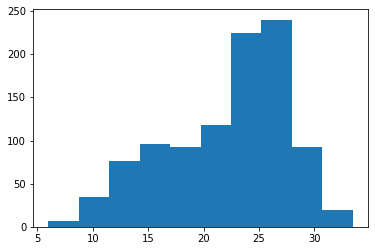

In [6]:
# Use stan to simulate draws from this mixutre model
simu_parameters = {'mu' : [15, 25],
                   'sigma' : 3, 
                   'w' : [0.3, 0.7], 
                   'N_obs' : 1000}

simu = simulation.sample(data=simu_parameters, fixed_param=True, 
                         iter_sampling=1, chains=1, seed=42)

# plot the simulation
y_simu = simu.stan_variable("y").values[0]
plt.hist(y_simu);

In [7]:
# compile the stan model
model_file = 'stan/simple_mixture.stan'
model = cmdstanpy.CmdStanModel(stan_file=model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/association/stan/simple_mixture
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/association/stan/simple_mixture


In [10]:
# fit the stan model
data = {'N_obs' : len(y_simu), 'y' : y_simu}

fit = model.sample(data=data, iter_sampling=1000, chains=1, seed=42)
#print(fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


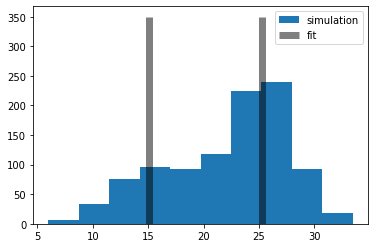

In [14]:
# plot the fit mu onto the simulated data
mu = fit.stan_variable("mu").values[0]
plt.hist(y_simu, label = 'simulation');
plt.vlines([mu[0], mu[1]], 0, 350, 
           linewidth = 7, alpha = 0.5, label = 'fit', color='k')
plt.legend()

## Explicit modelling of the association

In more physical applications, we want to know the rigorous probability for the association of an observation $y_i$ with a population component $k$. In order to do this, we basically want the marginal posterior for $\lambda$.

There are two things we can do in Stan to provide some useful information on this probability. 

* Save the values of the log probability `lp[i, k]` which correspsonds to $p(\lambda, y | \mu, \sigma)$. These can be marginalised to give $p(\lambda | \mu, \sigma, y)$
* Generate discrete samples based on `lp[i, k]` using a categorical RNG.

In [15]:
# compile a new model for the problem
explicit_model_file = 'stan/simple_mixture_explicit.stan'
explicit_model = cmdstanpy.CmdStanModel(stan_file=explicit_model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/association/stan/simple_mixture_explicit
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/association/stan/simple_mixture_explicit


In [25]:
# fit this model
explicit_fit = explicit_model.sample(data=data, iter_sampling=1000, 
                                     chains=4, seed=42)


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


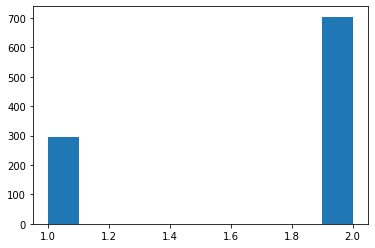

In [26]:
# plot the sampled labels (bit boring as we only have 2 components)
lam = explicit_fit.stan_variable("lambda").values[0]
plt.hist(lam);

### Probability that observation $i$ comes from component $k$

For each observation $y_i$, the value of the log probability `lp[i, k]` is the log of $p(\lambda = k, y_i | \mu, \sigma)$. Averaging over the posterior draws gives $q(\lambda = k | y_i, \mu, \sigma)$, which can be normalised to give the final result:

$$
p(\lambda = k | y_i, \mu, \sigma) = \frac{q(\lambda = k | y_i, \mu, \sigma)}{\sum_l q(\lambda = l | y_i, \mu, \sigma)}
$$

In [35]:
logprob = explicit_fit.stan_variable("lp").values
logprob = logprob.reshape(4000, 2, len(y_simu))
logprob = logprob.transpose(2, 1, 0)
np.shape(logprob)

(1000, 2, 4000)

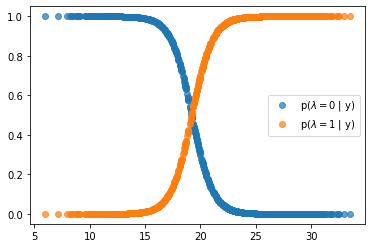

In [38]:
# answer: what is the probability that observation i comes from component k?

# find normalised marginal probability 
# associated with each observation
lp_l0 = []
lp_l1 = []
prob_l0 = []
prob_l1 = []
for i in range(len(y_simu)):
    # extract all iterations for all chains
    lp_i_l0 = logprob[i][0]
    lp_i_l1 = logprob[i][1]
    # exponentiate and average
    lp_l0.append(np.mean(np.exp(lp_i_l0)))
    lp_l1.append(np.mean(np.exp(lp_i_l1)))
    # normalise
    norm = (lp_l0[i] + lp_l1[i])
    prob_l0.append(lp_l0[i] / norm)
    prob_l1.append(lp_l1[i] / norm)

# plot the probabilities for different values of y_i
plt.scatter(y_simu, prob_l0, alpha = 0.7, label = 'p($\lambda = 0$ | y)')
plt.scatter(y_simu, prob_l1, alpha = 0.7, label = 'p($\lambda = 1$ | y)')
plt.legend()